### txt 파일 전처리

In [1]:
# 코드 인용 https://github.com/ssooni/data_mining_practice
import re
import pandas as pd
import datetime as dt

def read_kko_msg(filename):
    with open(filename, encoding='utf-8') as f:
        msg_list = f.readlines()
    return msg_list

def apply_kko_regex(msg_list):
    kko_pattern = re.compile("\[([\S\s]+)\] \[(오전|오후) ([0-9:\s]+)\] ([^\n]+)")
    kko_date_pattern = re.compile("--------------- ([0-9]+년 [0-9]+월 [0-9]+일) ")

    emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)

    kko_parse_result = list()
    cur_date = ""

    for msg in msg_list:
        # 날짜 부분인 경우
        if len(kko_date_pattern.findall(msg)) > 0:
            cur_date = dt.datetime.strptime(kko_date_pattern.findall(msg)[0], "%Y년 %m월 %d일")
            cur_date = cur_date.strftime("%Y-%m-%d")
        else:
            kko_pattern_result = kko_pattern.findall(msg)
            if len(kko_pattern_result) > 0:
                tokens = list(kko_pattern_result[0])
                # 이모지 데이터 삭제
                tokens[-1] = re.sub(emoji_pattern, "", tokens[-1])
                tokens.insert(0, cur_date)
                kko_parse_result.append(tokens)

    kko_parse_result = pd.DataFrame(kko_parse_result, columns=["Date", "Speaker", "timetype", "time", "contents"])
    kko_parse_result.to_csv("kko_regex.csv", index=False)

    return kko_parse_result

if __name__ == '__main__':
    msg_list = read_kko_msg("Group_Talk.txt")
    apply_kko_regex(msg_list)

# 전처리된 카카오톡 데이터를 불러와서 내용을 확인합니다.
df = pd.read_csv("./kko_regex.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098 entries, 0 to 1097
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1098 non-null   object
 1   Speaker   1098 non-null   object
 2   timetype  1098 non-null   object
 3   time      1098 non-null   object
 4   contents  1098 non-null   object
dtypes: object(5)
memory usage: 43.0+ KB
None


,Date,Speaker,timetype,time,contents
0,2021-06-14,김태환 형 17,오전,6:01,고민중ㅋㅋ
1,2021-06-14,이현직 16,오전,8:00,셤잘쳐
2,2021-06-14,김태환 형 17,오전,8:00,ㅋㅋㅋㅋ귀여워
3,2021-06-14,김태환 형 17,오전,10:07,시발
4,2021-06-14,김태환 형 17,오전,10:08,담배가 쓰다


In [2]:
# 메세지만 따로 불러옵니다.
corpus = df["contents"]
corpus

0                      고민중ㅋㅋ
1                        셤잘쳐
2                    ㅋㅋㅋㅋ귀여워
3                         시발
4                     담배가 쓰다
                ...         
1093    아니 난 잼민인인지 아닌지를 알고싶어
1094    그냥 픽창에서 잼민이 많으면 닷지하게
1095                      쓰발
1096                   잼민이뱃지
1097                이런거있음좋겧다
Name: contents, Length: 1098, dtype: object

In [3]:
# 데이터 전처리를 위한 전체 데이터의 특징을 빈도분석으로 파악해봅니다.
import nltk

total_tokens = [token for msg in corpus for token in str(msg).split()]
print(len(total_tokens))

2724


In [4]:
text = nltk.Text(total_tokens, name='kakao')
print(len(set(text.tokens)))
print(text.vocab().most_common(10))

1929
[('락원이', 28), ('난', 26), ('아', 23), ('진짜', 18), ('나', 18), ('오늘', 16), ('ㅋㅋ', 16), ('왜', 15), ('사진', 15), ('동현이', 14)]


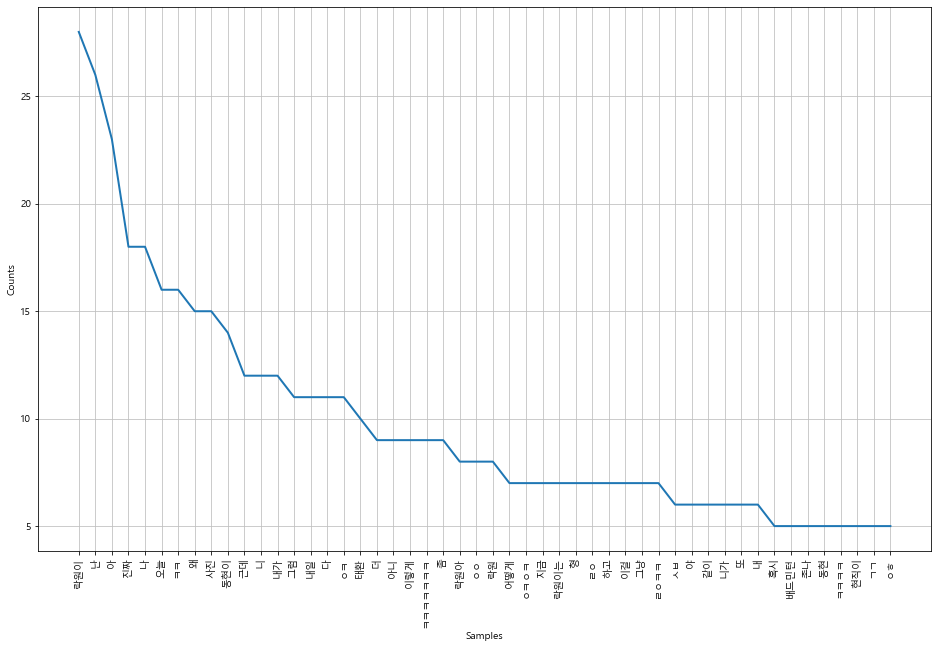

In [5]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

plt.figure(figsize=(16, 10))
text.plot(50)

In [6]:
import re

def message_cleaning(docs):

    """
        1. Photo, Emoticon은 그 내용을 알 수 없으므로 제거.
        
        2. 자음/모음 표현 처리방법.
        
            1) "ㅇㅇ" ,"ㅋㅋㅋㅋㅋ" 같은 자음만 존재하는 표현이나, "ㅡㅡ", "ㅠㅠ" 같은 모음만 존재하는 표현들은
            의미는 있으나 중요한 의미를 가지고 있지 않다고 판단하여 제거.
            
            2) 이러한 표현들도 전부 emoticon 같은 감정 표현의 의성어로 쓰거나, 단축 표현이므로 제거하지 않음. 
            
        3. http:// 로 시작하는 hyperlink 제거.
        
        4. 특수문자 제거.
    
    """
    # Series의 object를 str로 변경.
    docs = [str(doc) for doc in corpus]
    
    # 1
    pattern1 = re.compile("사진|Emoticon")
    docs = [pattern1.sub("", doc) for doc in docs]
    
    # 2
    pattern2 = re.compile("[ㄱ-ㅎ]*|[ㅏ-ㅣ]*")
    docs = [pattern2.sub("", doc) for doc in docs]
    
    # 3
    pattern3 = re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$\-@\.&+:/?=]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
    docs = [pattern3.sub("", doc) for doc in docs]
    
    # 4
    pattern4 = re.compile("[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]")
    docs = [pattern4.sub("", doc) for doc in docs]
    
    return docs

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding='utf-8') as f:
        for word in f:
            SW.add(word)
            
    return SW

def text_tokenizing(doc):
    return [word for word in mecab.morphs(doc) if word not in SW and len(word) > 1]
    
    # wordcloud를 위해 명사만 추출하는 경우.
    #return [word for word in mecab.nouns(doc) if word not in SW and len(word) > 1]

In [7]:
SW = define_stopwords("../Reference/stopwords-ko.txt")
# 카카오톡 텍스트를 정제합니다.
cleaned_corpus = message_cleaning(corpus)
print(len(cleaned_corpus))
print(cleaned_corpus[:10])

1098
['고민중', '셤잘쳐', '귀여워', '시발', '담배가 쓰다', '왜', '담배가 더 쓰다', '락원아', '동현이가 저녁 먹으러 오래', '오키오키']


In [8]:
# 정제되어 지워지는 텍스트들을 확인하고 지워줍니다.

cleaned_text = pd.Series(cleaned_corpus)
df["contents"] = cleaned_text
cleaned_data = df[df["contents"] != ""]
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 980 entries, 0 to 1097
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      980 non-null    object
 1   Speaker   980 non-null    object
 2   timetype  980 non-null    object
 3   time      980 non-null    object
 4   contents  980 non-null    object
dtypes: object(5)
memory usage: 45.9+ KB


In [9]:
#결과를 확인합니다.
cleaned_data.head()

,Date,Speaker,timetype,time,contents
0,2021-06-14,김태환 형 17,오전,6:01,고민중
1,2021-06-14,이현직 16,오전,8:00,셤잘쳐
2,2021-06-14,김태환 형 17,오전,8:00,귀여워
3,2021-06-14,김태환 형 17,오전,10:07,시발
4,2021-06-14,김태환 형 17,오전,10:08,담배가 쓰다


In [10]:
# 정제한 카카오톡 데이터를 저장합니다.

import pickle

with open("cleaned_data.pk", "wb") as f:
    pickle.dump(cleaned_data, f)